<a href="https://colab.research.google.com/github/GonzaloGmv/estrategias_de_decodificacion/blob/main/Decodificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estrategias de decodificación
### Puesta en marcha. Configuración.
Primero instalamos transformers y graphvitz, e instalamos las librerías locale y torch, y comenzamos con la configuración.

In [ ]:
%%capture

!sudo apt-get install graphviz graphviz-dev
!pip install transformers pygraphviz

import locale
locale.getpreferredencoding = lambda: "UTF-8"

import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Antecedentes
Introduciremos el texto "Once upon a time" en un
modelo GPT-2 y le pediremos que genere los siguientes cinco tokens.

In [61]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Usa la GPU si está disponible para hacer los cálculos, si no usaremos la CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Carga el modelo GPT-2 ya entrenado
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
# Carga el tokenizador para convertir el texto en secuencias de tokens comprensibles por el modelo
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

# Define el texto a partir del cual generará mas texto
text = "Once upon a time"
# Tokeniza el texto
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

# Genera texto a partir del anterior
outputs = model.generate(input_ids, max_length=len(input_ids.squeeze())+5)
# Decodifica el texto y lo imprime
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated text: {generated_text}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated text: Once upon a time, the world was a


### Búsqueda voraz
La búsqueda voraz es un método de decodificación que toma el token más probable en cada paso como el siguiente token en la secuencia.

In [62]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

# # Función para calcular el logaritmo de la probabilidad de un token
def get_log_prob(logits, token_id):
    # Calcula las probabilidades a partir de los logits usando softmax
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)

    # Obtiene el logaritmo de la probabilidad del token específico
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

# Función de búsqueda voraz para generar texto
def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids

    # Obtiene predicciones del modelo
    outputs = model(input_ids)
    predictions = outputs.logits

    # Obtiene el siguiente sub-token
    logits = predictions[0, -1, :]
    token_id = torch.argmax(logits).unsqueeze(0)

    # Calcula la puntuación del sub-token y lo agrega
    token_score = get_log_prob(logits, token_id)
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    # Agrega nodo y arista al grafo
    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    # Llamada recursiva para generar el siguiente token
    input_ids = greedy_search(new_input_ids, current_node, length-1)

    return input_ids

length = 5
beams = 1

# Creación de un árbol balanceado con altura 'length'
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

# Agrega los atributos tokenscore y token a cada nodo
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

# Genera el texto
output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")

Generated text: Once upon a time, the world was a


Visualizamos el arbol, con las respectivas puntuaciones para cada token.

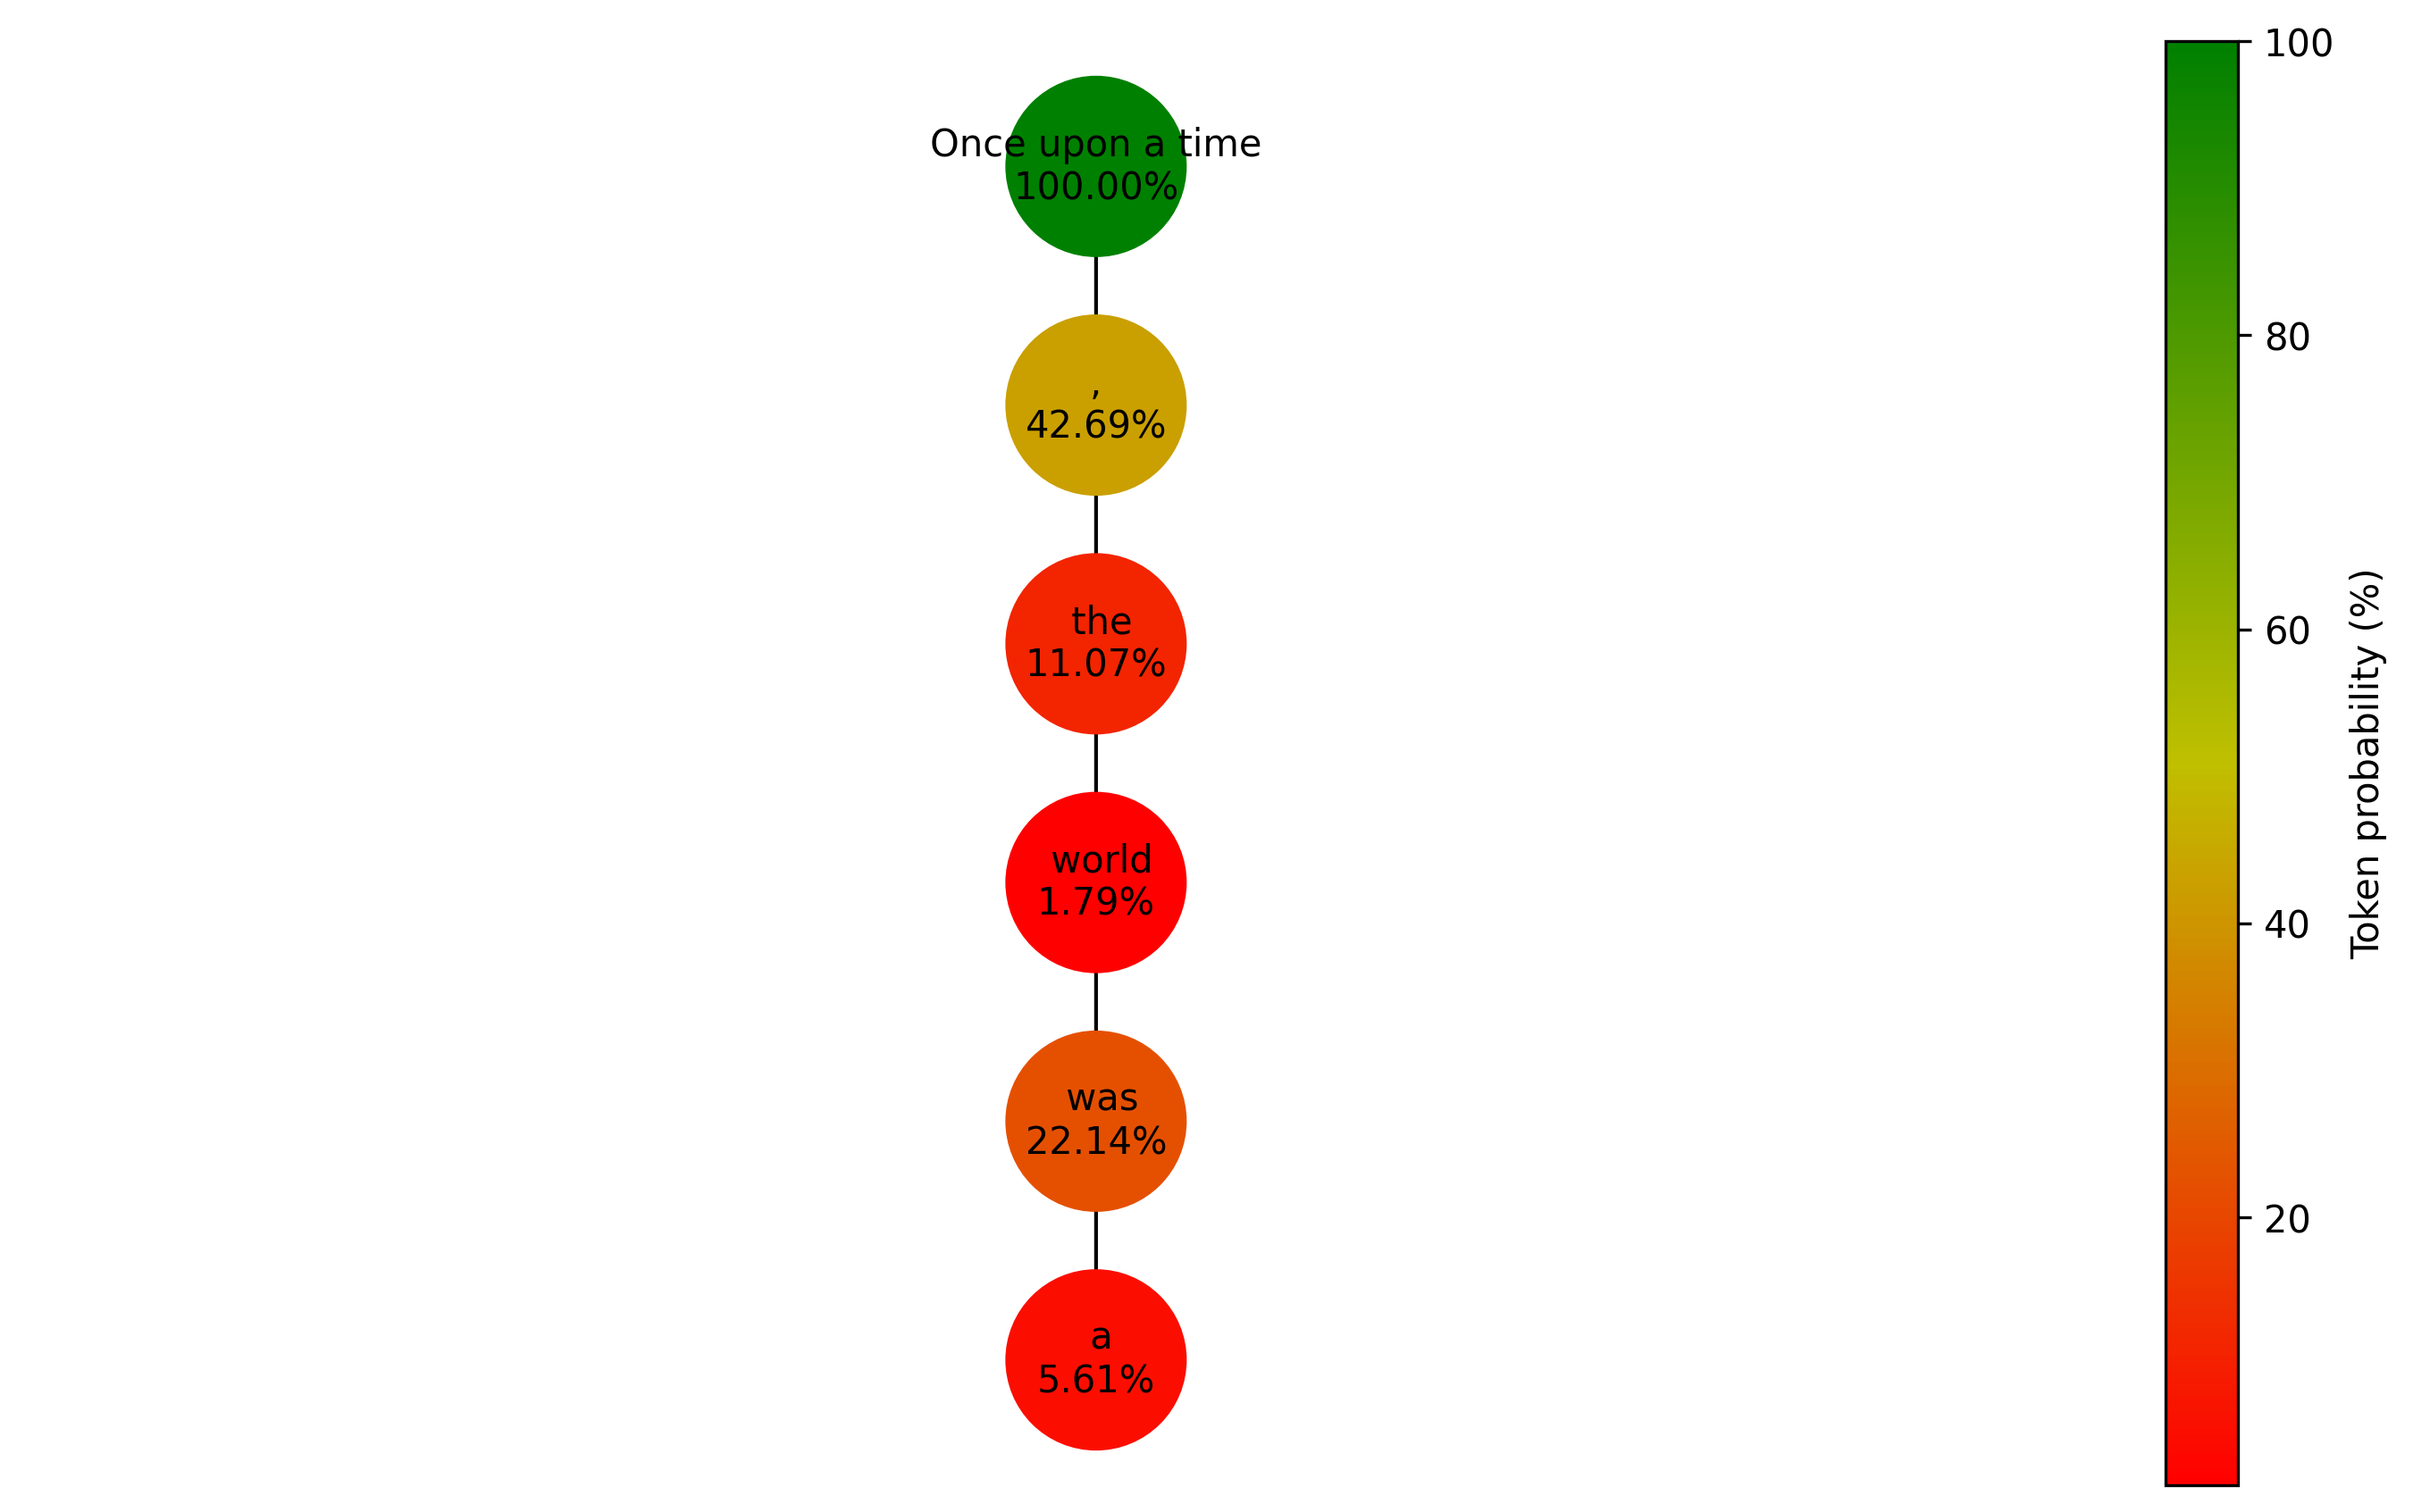

In [63]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# Función para graficar el grafo
def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')

    # Crea posiciones para cada nodo
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Normalizar los colores a lo largo del rango de puntuaciones de token o secuencia
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256)

    # Dibuja los nodos
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4,
                          node_color=scores, cmap=cmap)

    # Dibuja las aristas
    nx.draw_networkx_edges(graph, pos)

    # Dibuja las etiquetas de cada nodo
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencescore']:.2f}" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Agrega una barra de colores
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()

# Dibuja el grafo
plot_graph(graph, length, 1.5, 'token')

### Búsqueda de beams
A diferencia de la búsqueda codiciosa, que solo considera la siguiente ficha más probable,
la búsqueda por beams tiene en cuenta los n tokens más probables.

In [64]:
from tqdm.notebook import tqdm

# Función para realizar un muestreo voraz
def greedy_sampling(logits, beams):
    return torch.topk(logits, beams).indices

# Función para la busqueda de beams
def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    if length == 0:
        return None

    # Obtiene las salidas (outputs)
    outputs = model(input_ids)
    # Obtiene los logits de las predicciones
    predictions = outputs.logits

    # Obtiene los logits del último token generado
    logits = predictions[0, -1, :]

    # Muestreo voraz de los mejores tokens
    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    # Muestreo top-k
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    # Muestreo del núcleo
    elif sampling == 'nucleus':
        top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        # Obtiene la puntuación del token seleccionado
        token_score = get_log_prob(logits, token_id)
        # Calcula la puntuación acumulativa
        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        # Agrega el token a la secuencia
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        # Decodifica el token
        token = tokenizer.decode(token_id, skip_special_tokens=True)
        # Obtiene el nodo sucesor
        current_node = list(graph.successors(node))[j]
        # Almacena las puntuaciones
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1/(len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length}_{j}"

        # Llamada recursiva para seguir generando
        beam_search(new_input_ids, current_node, bar, length-1, beams, sampling, 1)

# Longitud del texto generado y número de beams
length = 5
beams = 2

# Crea el arbol
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Agrega atributos al arbol
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = text

# Inicia la busqueda de beams
beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)


  0%|          | 0/63 [00:00<?, ?it/s]

A continuaciín extraemos los tokens con mejor frecuencia.

In [65]:
def get_best_sequence(G):
    # Cre una lista de nodos
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node)==0]

    # Obtiene el nodo con la mayor puntuación
    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['sequencescore'] > max_score:
            max_score = G.nodes[node]['sequencescore']
            max_score_node = node

    # Recoge la secuencia de nodos desde este nodo hasta el nodo raiz en una lista
    path = nx.shortest_path(G, source=0, target=max_score_node)

    # Devuelve la cadena de tokens
    sequence = "".join([G.nodes[node]['token'].split('_')[0] for node in path])

    return sequence, max_score

# Llama a la función para obtener la mejor secuencia del grafo
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: Once upon a time, I was in a


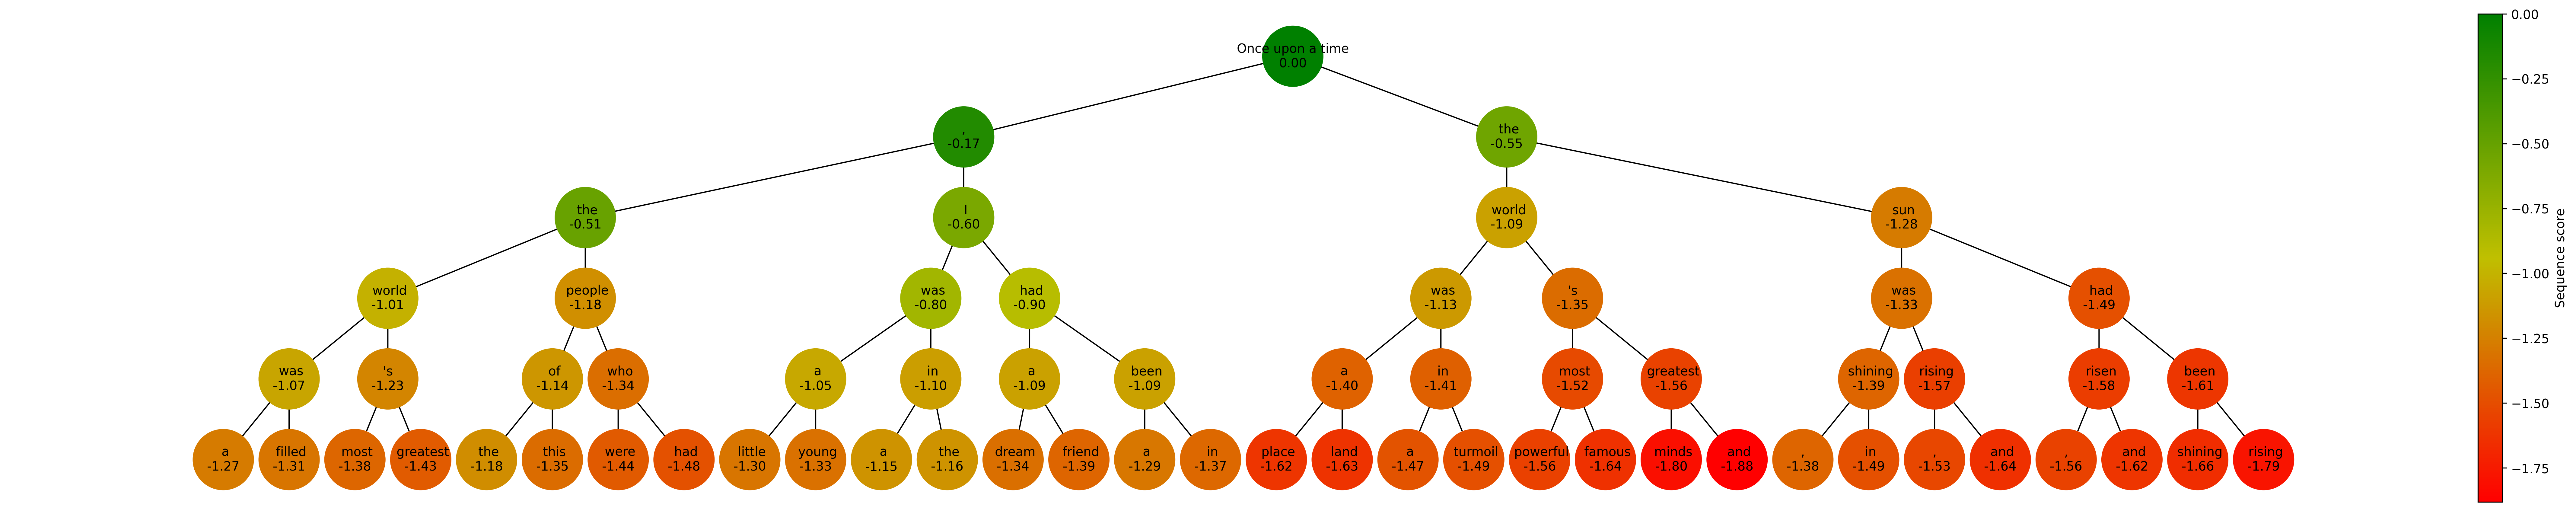

In [66]:
# Imprimimos el grafo
plot_graph(graph, length, beams, 'sequence')

### Muestreo top-k
El muestreo Top-k es una técnica que aprovecha la distribución de probabilidad generada
por el modelo de lenguaje para seleccionar un token al azar de las k opciones más
probables

In [67]:
def plot_prob_distribution(probabilities, next_tokens, sampling, potential_nb, total_nb=50):
    # Obtener los top k tokens
    top_k_prob, top_k_indices = torch.topk(probabilities, total_nb)
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices.tolist()]

    # Obtener los siguientes tokens y sus probabilidades
    next_tokens_list = [tokenizer.decode([idx]) for idx in next_tokens.tolist()]
    next_token_prob = probabilities[next_tokens].tolist()

    # Crear la figura
    plt.figure(figsize=(0.4*total_nb, 5), dpi=300, facecolor='white')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    if potential_nb < total_nb:
        plt.axvline(x=potential_nb-0.5, ls=':', color='grey', label='Sampled tokens')
    plt.bar(top_k_tokens, top_k_prob.tolist(), color='blue')
    plt.bar(next_tokens_list, next_token_prob, color='red', label='Selected tokens')
    plt.xticks(rotation=45, ha='right', va='top')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if sampling == 'top_k':
        plt.title('Probability distribution of predicted tokens with top-k sampling')
    elif sampling == 'nucleus':
        plt.title('Probability distribution of predicted tokens with nucleus sampling')
    plt.legend()
    plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)
    plt.close()

# Función de muestreo top-k
def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float('-inf')

    # Convierte los logits en probabilidades
    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)

    # Muestrea los n tokens de la distribución
    next_tokens = torch.multinomial(probabilities, beams)

    # Grafica la distribución
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'top_k', top_k)

    return next_tokens

# Inicia la generalización de texto
beam_search(input_ids, 0, bar, length, beams, 'top_k', 1)

In [68]:
# Imprime el texto generado
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: Once upon a time, in the middle of


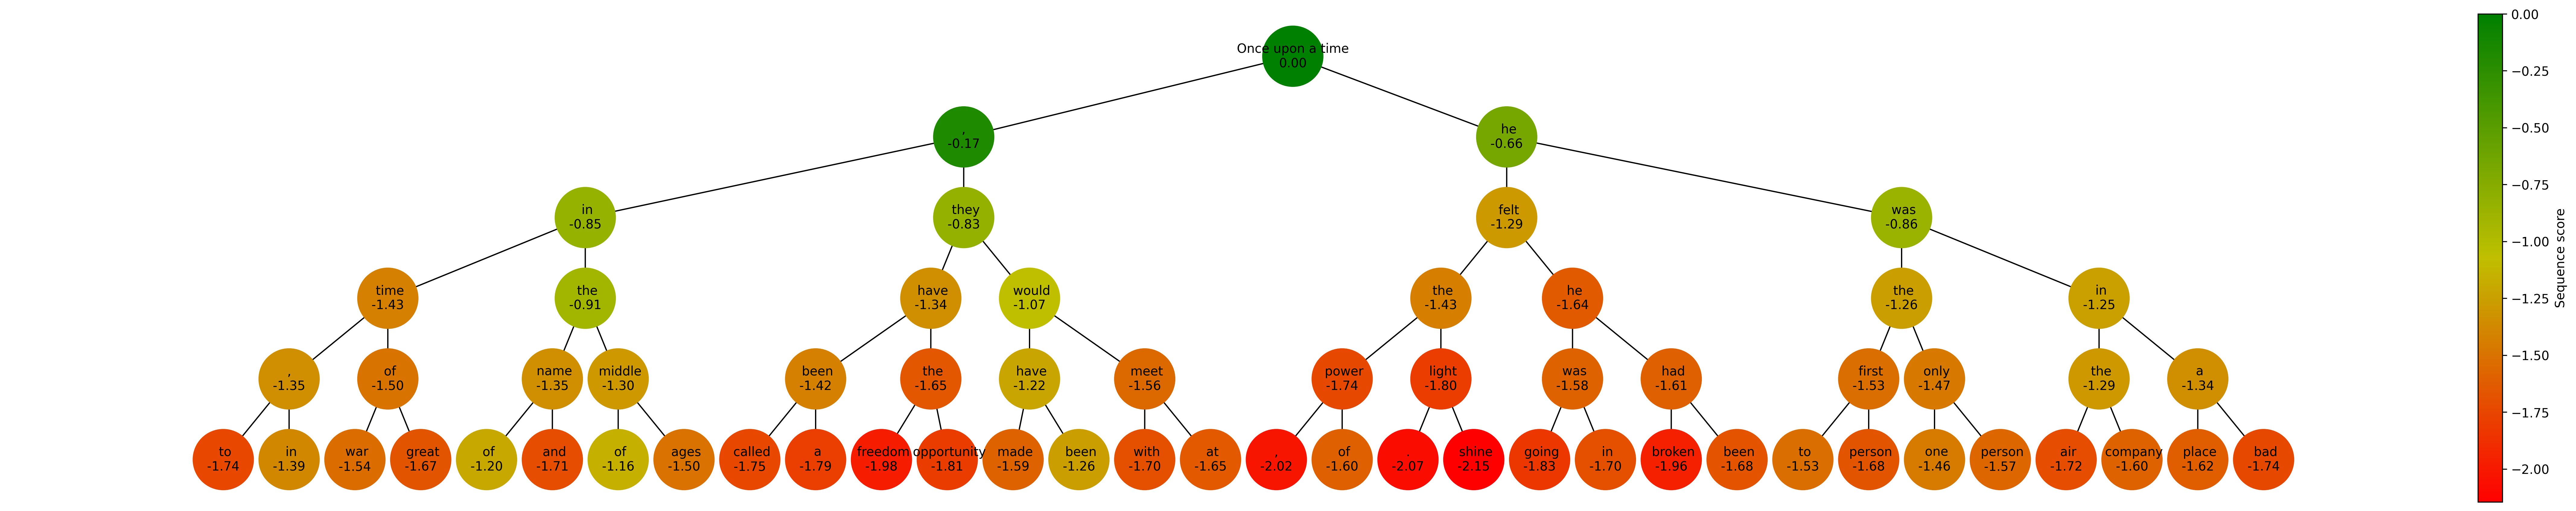

In [69]:
# Dibuja la gráfica
plot_graph(graph, length, beams, 'sequence')

### Muestreo de núcleo
El muestreo de núcleo elige un valor de corte p tal que la suma de las probabilidades de las fichas seleccionadas exceda p. Esto forma un "núcleo" de fichas de las que elegir aleatoriamente la siguiente ficha.


In [73]:
def nucleus_sampling(logits, temperature, p, beams, plot=True):
    assert p > 0
    assert p <= 1

    # Ordena las probabilidades en orden descendiente y calcula las probabilidades acumulativas
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

    # Crea una máscara para las probabilidades que están en el top-p
    mask = cumulative_probabilities < p

    # Utilizamos los mejores n tokens, si no hay un índice n donde cumulative_probabilities < p
    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    # Guarda solo los índices top-p
    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float('-inf')

    # Muestrea n tokens de la distribución resultante
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    # Grafica la distribución
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'nucleus', top_p_index_to_keep)

    return next_tokens

# Inicializa la generación de texto
beam_search(input_ids, 0, bar, length, beams, 'nucleus', 1)

In [74]:
# Imprime el texto generado
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: Once upon a time, I thought I was


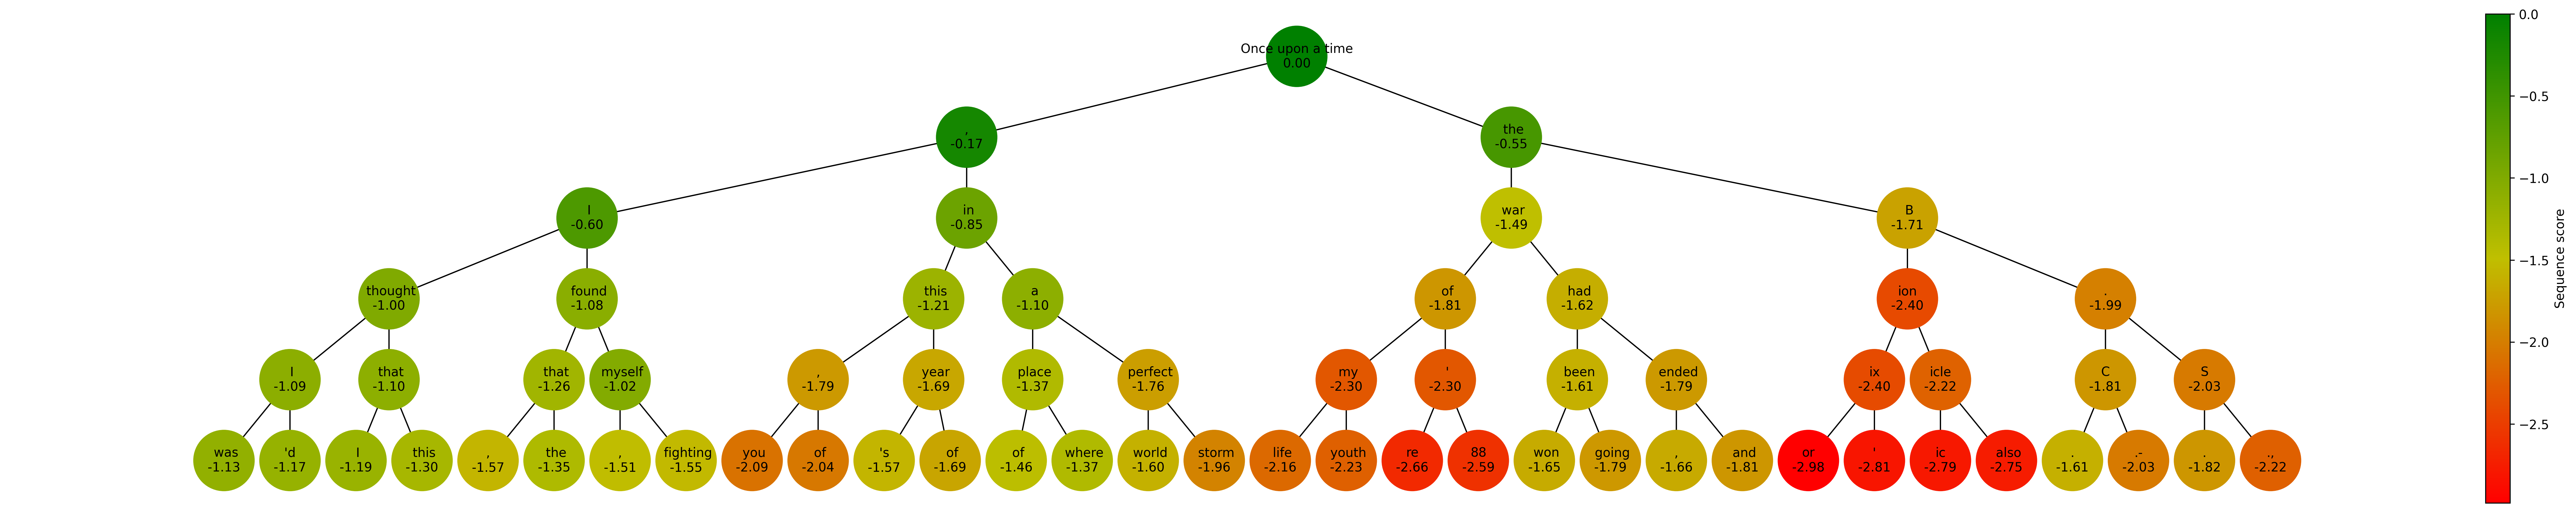

In [75]:
# Dibuja la gráfica
plot_graph(graph, length, beams, 'sequence')